In [263]:
import warnings

warnings.filterwarnings('ignore')

# 数据读入模块

In [264]:
import pandas as pd


train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [265]:
import os
filenames = ["data\detail\df_basic_b1.csv",
              "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
              "data\detail\df_loan2_b1.csv",
              "data\detail\df_query_b1.csv"
             ]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [266]:
industry_df=pd.read_csv("data\detail\df_corp_b1.csv")
industry_df=industry_df.groupby('industry')['cust_id'].count()
industry_df=pd.DataFrame({"industry_num":industry_df})

train_data = pd.merge(train_data, industry_df, on="industry",
                          how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, industry_df, on="industry",
                         how="left", suffixes=("", "_y"))

In [267]:
industry_df=pd.read_csv("data\detail\df_corp_b1.csv")
industry_df=industry_df.groupby('scope')['cust_id'].count()
industry_df=pd.DataFrame({"scope_num":industry_df})

train_data = pd.merge(train_data, industry_df, on="scope",
                          how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, industry_df, on="scope",
                         how="left", suffixes=("", "_y"))

In [268]:
train_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in test_data['judicial_reason']]


In [269]:
# train_data['nan_num'] = (train_data == 0).astype(int).sum(axis=1)
# test_data['nan_num'] = (test_data == 0).astype(int).sum(axis=1)


In [270]:
drop_col=[]
woe_col=[]
onehot_col=[]



train_data.drop(drop_col,inplace=True)
test_data.drop(drop_col,inplace=True)

## loan1表

In [271]:
if True:

    import pandas as pd
    temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")
    temp_df=temp_df.dropna(axis=0,subset = ["date_1"])   

    def chuli_loan(df, colname, ways):
        cust_id = list(set(df['cust_id']))
        res_df = pd.DataFrame({'cust_id': cust_id})
        try:
            temp_train = pd.read_csv('./data/df_train.csv')
            temp_test = pd.read_csv('./data/df_test.csv')
            temp = list(temp_test.columns)
        except:
            temp = []

        ways_1 = []

        global train_data, test_data

        for i in ways:
            if (colname+'_'+i) not in temp:
                ways_1.append(i)
                res_df[colname+'_'+i] = None
            else:
                print(colname+'_'+i+'已存在')
                train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                      how="left", suffixes=("", "_y"))
                test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                     how="left", suffixes=("", "_y"))
        ways = ways_1
        if len(ways) == 0:
            return res_df
        if 'mean' in ways:
            res_df[colname+'_mean'] = df.groupby('cust_id')[colname].mean()
        if 'sum' in ways:
            res_df[colname+'_sum'] = df.groupby('cust_id')[colname].sum()
        if 'count' in ways:
            res_df[colname+'_count'] = df.groupby('cust_id')[colname].count()
        if 'std' in ways:
            res_df[colname+'_std'] = df.groupby('cust_id')[colname].std()
        if 'diff_std' in ways:
            res_df[colname+'_diff_std'] = df.groupby('cust_id')[colname].apply(lambda x:x.sort_values(ascending=True).diff()[2:].std())
        return res_df

    for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
        df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count', 'std'))
        train_data = pd.merge(train_data, df, on="cust_id",
                              how="left", suffixes=("", "_y"))
        test_data = pd.merge(test_data, df, on="cust_id",
                             how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'date_3', ('count',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'date_1', ('std','diff_std'))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'loan1_10', ('mean',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'loan1_11', ('sum',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'loan1_12', ('sum',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    train_data.to_csv('./data/df_train.csv')
    test_data.to_csv('./data/df_test.csv')


loan1_1_mean已存在
loan1_1_sum已存在
loan1_1_count已存在
loan1_1_std已存在
loan1_3_mean已存在
loan1_3_sum已存在
loan1_3_count已存在
loan1_3_std已存在
loan1_7_mean已存在
loan1_7_sum已存在
loan1_7_count已存在
loan1_7_std已存在
loan1_9_mean已存在
loan1_9_sum已存在
loan1_9_count已存在
loan1_9_std已存在
date_3_count已存在
date_1_std已存在
date_1_diff_std已存在
loan1_10_mean已存在
loan1_11_sum已存在
loan1_12_sum已存在


In [272]:
# data = temp_df.dropna(axis=0,subset = ["date_1"])   
# data['date2-date1'] = data['date_2'] - data['date_1']
# data['date3-date2'] = data['date_3'] - data['date_2']
# data['dateinterval_max'] = data[['date2-date1','date3-date2']].max(axis=1)
# data = data.groupby('cust_id').agg({'date_2':['count'],'date_3':['count'],'dateinterval_max':['mean']})
# train_data = pd.merge(train_data, data, on="cust_id",
#                           how="left", suffixes=("", "_y"))
# test_data = pd.merge(test_data, data, on="cust_id",
#                          how="left", suffixes=("", "_y"))

## 处理NAN

In [273]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [274]:
df_train = delnan(train_data)
df_test = delnan(test_data)


## 处理-99

In [275]:
# df_train.replace(-99, -1, inplace=True)
# df_test.replace(-99, -1, inplace=True)


## 主成分分析（效果不好）

In [276]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]


## 处理分类变量

In [277]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",
            "loan2_1_y",
            "query_2_y",
            "query_3_y",
            "query_4_y",
            "query_5_y",
            "query_6_y", ]


## 转化为one-hot编码（不宜采用）

In [278]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


# df_train = to_one_hot(df_train, type_col)
# df_test = to_one_hot(df_test, type_col)
# for i in df_train.columns:
#     if i not in df_test.columns:
#         df_test[i] = 0


## 证据权重

In [279]:
import pandas as pd
import numpy as np


def cal_woe(df, df_no_label, x_cols, y_col):
    for i in x_cols:
        x_set = pd.unique(df[i])
        x1_set = pd.unique(df_no_label[i])
        for j in x1_set:
            if j not in x_set:
                df_no_label[i].replace(j, 0.03, inplace=True)
                print(i, j, '不存在')
        for j in x_set:
            woe = np.mean(df[df[i] == j][y_col])
            if woe >= 0.1:
                n = np.sum(df[df[i] == j][y_col])
                print(i, '列：', j, ' 共有', int(n/woe), '个,其中',
                      int(n), '个label为1,woe为', woe, sep="")
            df[i].replace(j, woe, inplace=True)
            df_no_label[i].replace(j, woe, inplace=True)
    return df, df_no_label


In [280]:
# df_train, df_test = cal_woe(df_train, df_test, type_col, "label")


In [281]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col = [i for i in full_col_name if "judicial" in i]
date_col=[i for i in full_col_name if "date" in i]
# loan_pca_col = [i for i in full_col_name if "loan_pca" in i]

# for i in judicial_col:
#     df_train[i].astype("float")
#     df_test[i].astype("float")


## rank化

In [282]:
def rank(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# rank(c)


## 归一化

In [283]:
def norm(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


# norm([i for i in loan_col if i not in type_col and 'count' not in i])


## 标准化

In [284]:
def stand(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.mean(df[i], axis=0))/np.std(df[i], axis=0)
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


# stand([i for i in loan_col if i not in type_col and 'count' not in i])


## 设置哪些x作为模型自变量输入

In [285]:
date_col

['date_1', 'date_3_count', 'date_1_std', 'date_1_diff_std']

In [286]:
# x_col = basic_col+loan_col+['nan_num'] + ['is_judicial']+ overdue_col+query_col
x_col = basic_col+['is_judicial']+loan_col+query_col+overdue_col+['scope_num']+['industry_num']

type_col=[i for i in type_col if i in x_col]
#categorize(df_train,type_col)
#categorize(df_test,type_col)

print('自变量个数为', len(x_col))


自变量个数为 136


In [287]:
df_train=df_train[x_col+['label','cust_id']]
df_test=df_test[x_col+['cust_id']]

df_test.to_csv("test_input.csv", encoding='utf-8')
df_train.to_csv("train_input.csv", encoding='utf-8')


# 训练模型

## 超参数

In [288]:
N = 100
num_round = 300
local_test_size = 3000

max_depth = [3, 4, 5,6,7,8]
eta = [0.1,0.06]
colsample_bytree = [0.8, 0.7, 0.6, 0.5]
scale_pos_weight = [1, 3, 6, 10, 20, 30]
test_size = [0.3, 0.4, 0.5, 0.6, 0.7]
subsample = [0.7, 0.6, 0.5, 0.4]
par_lambda = [1, 1.5, 2, 3]
alpha = [0, 0.2, 0.4, 0.6, 0.8]
min_child_weight = [1, 2, 3, 4, 5, 6, 10]
gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

feature_fraction=[1,0.9,0.8,0.7]
max_bin=[16,32,64,128]
num_leaves=[32,64,80,128]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [289]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import early_stopping,log_evaluation


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag = 0
important_x_seq = []


d_full = xgb.DMatrix(df_train[x_col], label=df_train['label'])
X = df_train[x_col]
Y = df_train['label']

X, X_local_test, Y, Y_local_test = model_selection.train_test_split(
    X, Y, test_size=local_test_size, stratify=Y,random_state=2022)

d_localtest = xgb.DMatrix(X_local_test, label=Y_local_test)
x_perd = xgb.DMatrix(df_test[x_col])

d_localtest1 = lgb.Dataset(X_local_test, Y_local_test)
x_perd1 = lgb.Dataset(df_test[x_col])


lgbcallback=[early_stopping(10),log_evaluation(10000)]

In [290]:

for i in range(N):

    #seed = 666
    test_size_this_round = random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round, stratify=Y)
    # seed+=1

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]
    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample': random.choice(subsample),
        'alpha': random.choice(alpha),
        'lambda': random.choice(par_lambda),
        'min_child_weight': random.choice(min_child_weight),
        'gamma': random.choice(gamma),
        # 'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=20, verbose_eval=False)

    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])
    global_auc = float(bst.eval(d_full).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(d_localtest))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc': local_test_loss,
                 'model':'xgb'}

    # info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag == 0:
        info_df = pd.DataFrame(temp_dict, index=[i])
        flag = 1
    else:
        info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])

    # if loss > max_auc_loss:
    #     best_bst = copy.deepcopy(bst)
    #     max_auc_loss = loss

    if False:
        pic = xgb.plot_importance(bst, max_num_features=50)
        temp = pic.get_ymajorticklabels()
        important_x = [str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq += important_x

    # print(i+1, ":", loss, sep="")
    # print(param)
    # print("-------------------------")
    pred_labels.append(copy.deepcopy(pred_label))
    local_test_labels.append(copy.deepcopy(test_label))

    param = {
        'task': 'train',
        "max_bin": random.choice(max_bin),
        "max_depth": random.choice(max_depth),
        'boosting_type': 'gbdt',  # 设置提升类型
        'objective': 'binary',  # 目标函数
        'metric': 'auc',  # 评估函数
        'num_leaves': random.choice(num_leaves),  # 叶子节点数
        'learning_rate': random.choice(eta),  # 学习速率
        # 建树的特征选择比例
        'feature_fraction': random.choice(feature_fraction),
        #'bagging_fraction': random.choice(subsample),  # 建树的样本采样比例
        'lambda_l1': random.choice(alpha),
        'lambda_l2': random.choice(gamma),
        'bagging_freq': 1,  # k 意味着每 k 次迭代执行bagging
        'min_data_in_leaf': 1,
        'verbose': -100,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
        'device_type': 'gpu',
    }

    

    dtrain = lgb.Dataset(X_train, y_train)
    dtest = lgb.Dataset(X_test, y_test)
    bst = lgb.train(param, dtrain, num_round, valid_sets=[
                    dtest], callbacks=lgbcallback,categorical_feature=type_col)

    loss = roc_auc_score(y_test, bst.predict(X_test))
    train_loss = roc_auc_score(y_train, bst.predict(X_train))
    local_test_loss = roc_auc_score(Y_local_test, bst.predict(X_local_test))
    global_auc = roc_auc_score(df_train['label'], bst.predict(df_train[x_col]))

    pred_label = list(bst.predict(df_test[x_col]))
    test_label = list(bst.predict(X_local_test))

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc': local_test_loss,
                 'model':'lgb'}

    info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])
    pred_labels.append(copy.deepcopy(pred_label))
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.684884
Early stopping, best iteration is:
[55]	valid_0's auc: 0.694242
Early stopping, best iteration is:
[55]	valid_0's auc: 0.694242
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	valid_0's auc: 0.735636
Early stopping, best iteration is:
[33]	val

In [291]:
info_df


,test_auc,train_auc,local_test_auc,model
0,0.693105,0.943770,0.700016,xgb
0,0.684884,0.998126,0.680872,lgb
1,0.692017,0.999959,0.680655,xgb
1,0.694242,0.994140,0.706349,lgb
2,0.681796,1.000000,0.627454,xgb
...,...,...,...,...
97,0.706103,0.917968,0.673893,lgb
98,0.670319,0.997519,0.653321,xgb
98,0.676961,0.999829,0.670253,lgb
99,0.670784,0.894287,0.658679,xgb


In [292]:
info_df.to_csv("info.csv", encoding="utf-8", index=False)


In [293]:
# pic = xgb.plot_importance(bst, max_num_features=50)
# temp = pic.get_ymajorticklabels()
# important_x = [str(i).split("\'")[1] for i in temp]
# important_x.reverse()


In [294]:
# important_x


In [295]:
# pd.value_counts(important_x_seq)


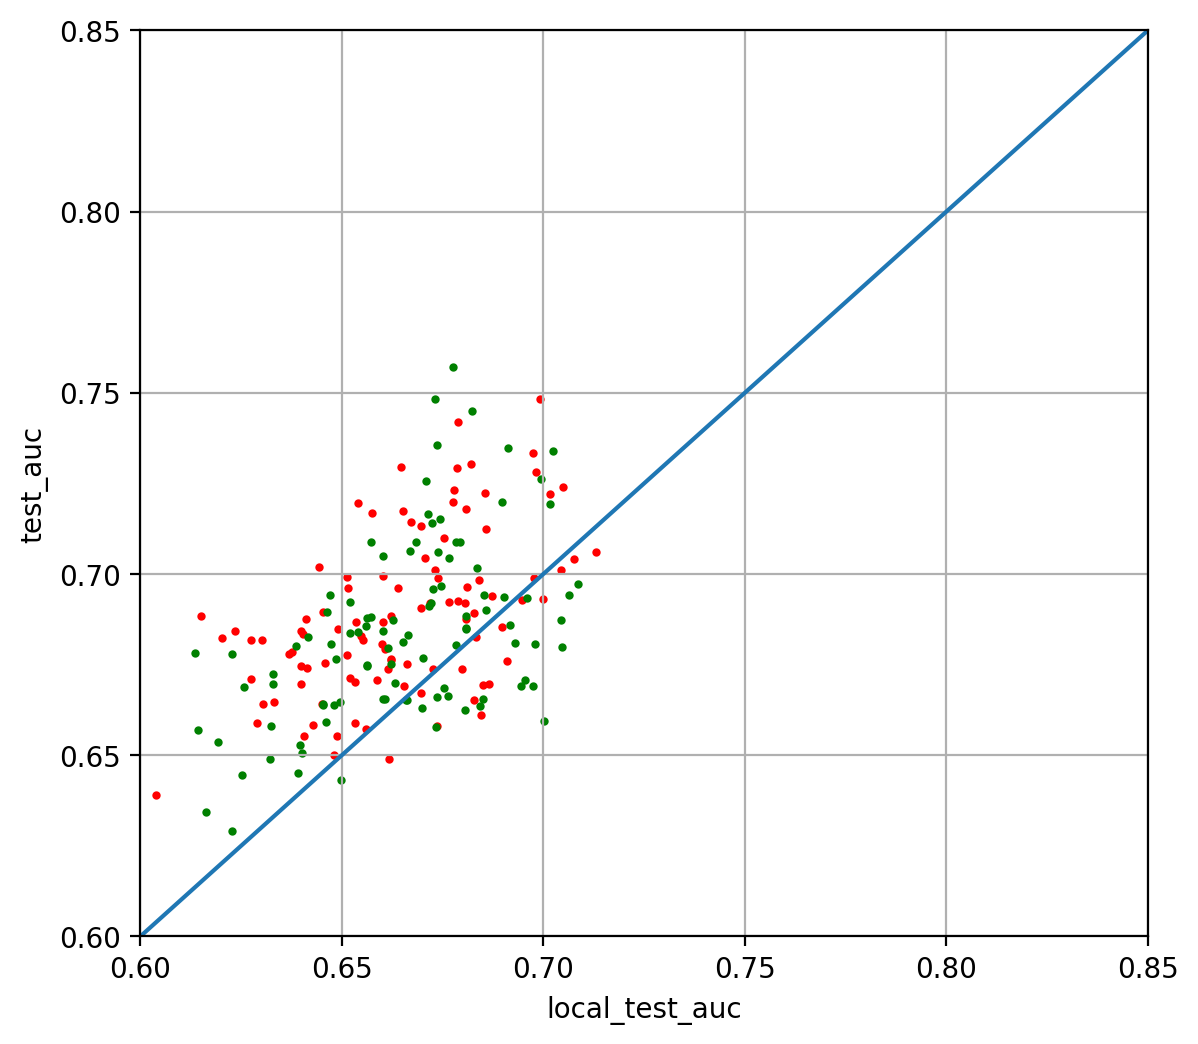

In [296]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6.5, 6), dpi=200)
plt.scatter(info_df[info_df['model']=='xgb']['local_test_auc'], info_df[info_df['model']=='xgb']['test_auc'],
            c='r', s=4)
plt.scatter(info_df[info_df['model']=='lgb']['local_test_auc'], info_df[info_df['model']=='lgb']['test_auc'],
c='g', s=4)
plt.xlabel('local_test_auc')
plt.ylabel('test_auc')
plt.plot([0.6, 0.85], [0.6, 0.85])
plt.xlim(0.6, 0.85)
plt.ylim(0.6, 0.85)
plt.grid()
plt.show()


# 输出模块

In [297]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in (info_df['local_test_auc'])])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    auc_seq = []
    for i in range(round(N/5)):
        list_temp.append(local_test_labels[res_num[i]])
        # 算数平均
        # temp = np.mean(list_temp, axis=0)
        # 几何平均(better)
        temp = np.exp(np.mean(np.log(list_temp), axis=0))
        temp_auc = roc_auc_score(Y_local_test, temp)
        # print(i, temp_auc)
        auc_seq.append(temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 40
    n = min(N, n)

res_num = res_num[0:n]

#final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
final_pred_label = np.exp(
    np.mean(np.log([pred_labels[i] for i in res_num]), axis=0))
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [
      list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后local_test_AUC为", max_auc, sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前8个auc为[0.7129967929200666, 0.7086293454579901, 0.7075366378435433, 0.7063492063492063, 0.7049384971379856, 0.7046204955412116, 0.7043836858414864, 0.7043261749144102]
平均之后local_test_AUC为0.7432035616178839


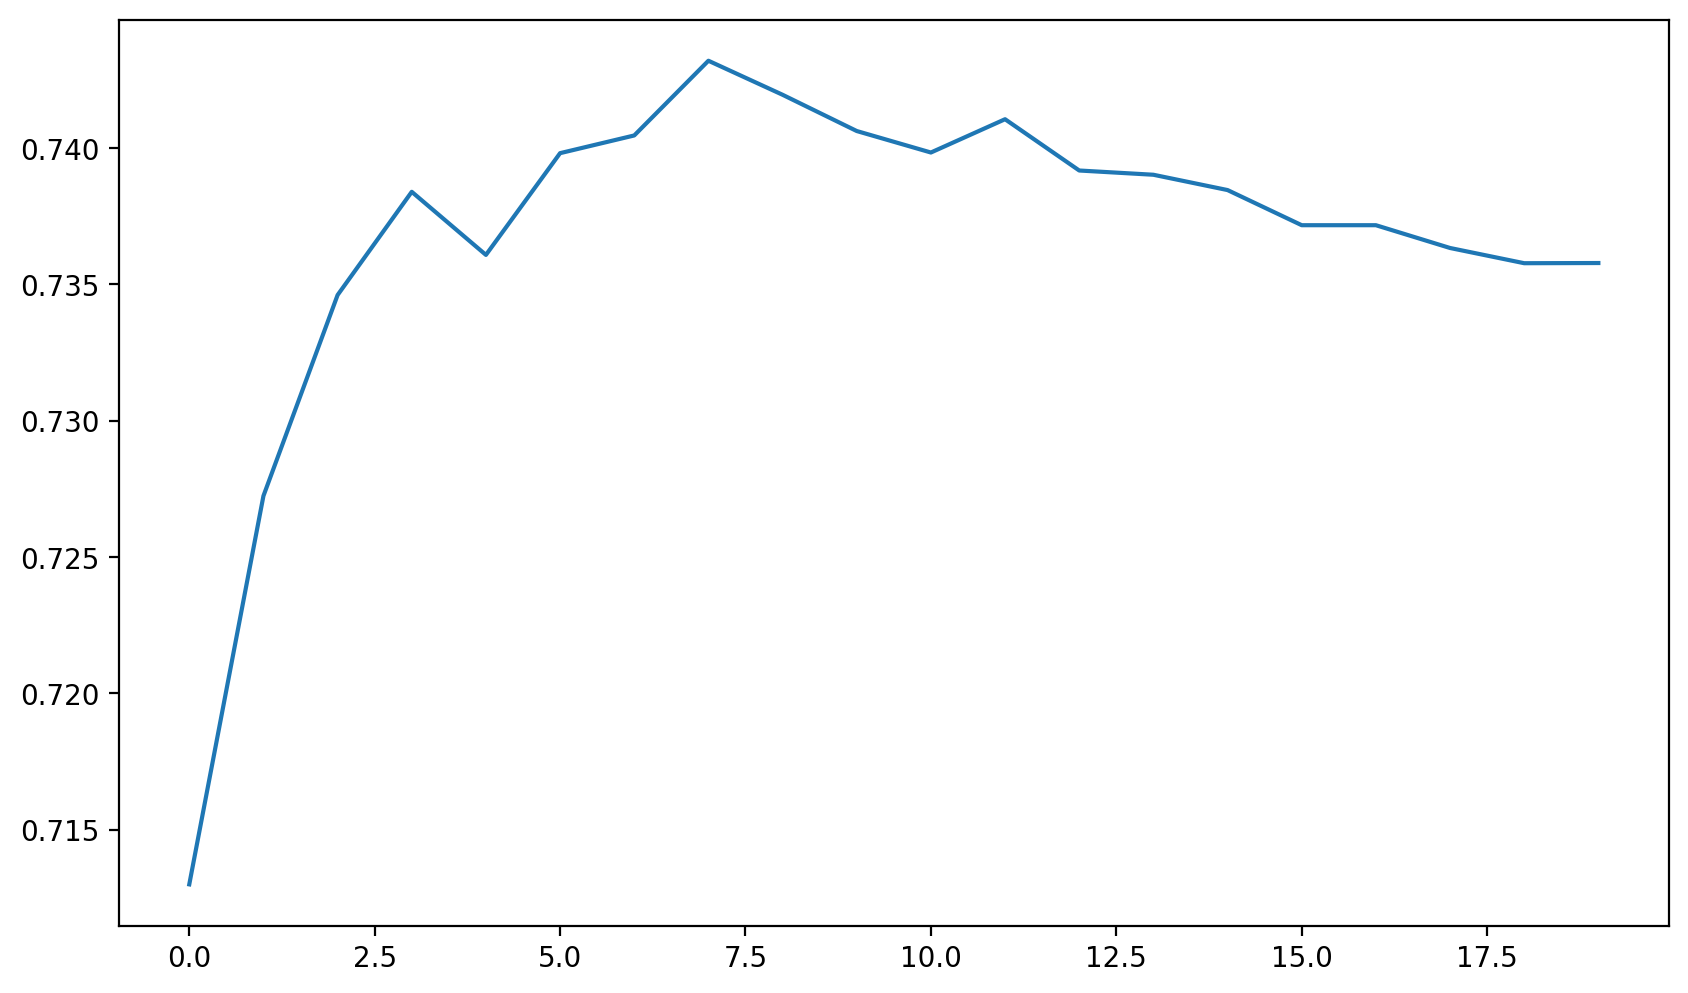

In [298]:

plt.figure(figsize=(10, 6), dpi=200)
plt.plot(list(range(len(auc_seq))), auc_seq)


# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用
## 10-18
* 不能把industry之类种类很多的分类变量做证据权重

# 记录
* 1014-4
  * 0.6823
  * 证据权重
  * 未添加贷款记录表
  * 按test auc排序
* 1014-5
  * 0.6925
  * 按local test auc排序
* 1015-1
  * 0.6834
  * 处理-99
* 1015-2
  * 0.6628
  * 添加贷款记录表
* 1015-3
  * 0.6772
  * 不处理-99
  * 去除贷款记录表
  * 添加了type-col
* 1015-4
  * 0.6811
  * 不做证据权重
* 1015-5
  * 0.6765
  * gamma=0
* 1016-1
  * 0.6798
  * 添加gamma
  * 增大early stop round
* 1016-2
  * 0.6858
  * early stop round=10
  * 证据权重
* 1016-3
  * 0.685799
  * 使用原始type-col
* 1017-2
  * 0.6655
